In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from data_loader import load_and_prepare_data
from evaluate import save_confusion_matrix, save_metrics
from model import get_tokenizer
from transformers import BertForSequenceClassification
import torch
import numpy as np
from pathlib import Path
from transformers import Trainer

### Reload Saved Model and Tokenizer

In [4]:
model_path = Path("..") / "outputs" / "model"

# Load trained model and tokenizer
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = get_tokenizer().from_pretrained(model_path)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Prepare Validation Data for Evaluation

In [6]:
# Reload test split and labels using same preprocessing logic as training
train_texts, test_texts, train_labels, test_labels, label_encoder = load_and_prepare_data()

# Tokenize test texts
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Wrap validation data in custom dataset class
from torch.utils.data import Dataset

class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {"labels": torch.tensor(self.labels[idx])}

test_dataset = EmotionDataset(test_encodings, test_labels)

### Generate Predictions using the Hugging Face Trainer

In [8]:
# Initialize Hugging Face Trainer with the loaded model
trainer = Trainer(model=model)

# Generate raw predictions
predictions = trainer.predict(test_dataset)

# Extract labels and predicted classes
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

### Generate the Classification Report

In [10]:
from sklearn.metrics import classification_report

# Create and print the classification report
report = classification_report(
    y_true, 
    y_pred, 
    target_names=label_encoder.classes_,
    zero_division=0
)
print("Classification Report:\n")
print(report)

# Also save it as JSON
from sklearn.metrics import classification_report
import json
from pathlib import Path

metrics_dir = Path("..") / "outputs" / "metrics"
metrics_dir.mkdir(parents=True, exist_ok=True)

# Save the report in dictionary form for precision/recall/F1
report_dict = classification_report(
    y_true, 
    y_pred, 
    target_names=label_encoder.classes_, 
    output_dict=True,
    zero_division=0)

with open(metrics_dir / "report.json", "w") as f:
    json.dump(report_dict, f, indent=4)

Classification Report:

                precision    recall  f1-score   support

    admiration       0.67      0.76      0.71       542
     amusement       0.73      0.85      0.78       330
         anger       0.43      0.55      0.48       205
     annoyance       0.30      0.19      0.23       290
      approval       0.38      0.37      0.38       375
        caring       0.38      0.48      0.42       130
     confusion       0.50      0.42      0.46       172
     curiosity       0.46      0.60      0.52       278
        desire       0.64      0.53      0.58        78
disappointment       0.33      0.20      0.25       142
   disapproval       0.32      0.48      0.39       280
       disgust       0.51      0.45      0.48       100
 embarrassment       0.79      0.56      0.66        41
    excitement       0.42      0.31      0.36       102
          fear       0.81      0.50      0.62        86
     gratitude       0.91      0.88      0.90       371
         grief       0.

### Plot the Confusion Matrix

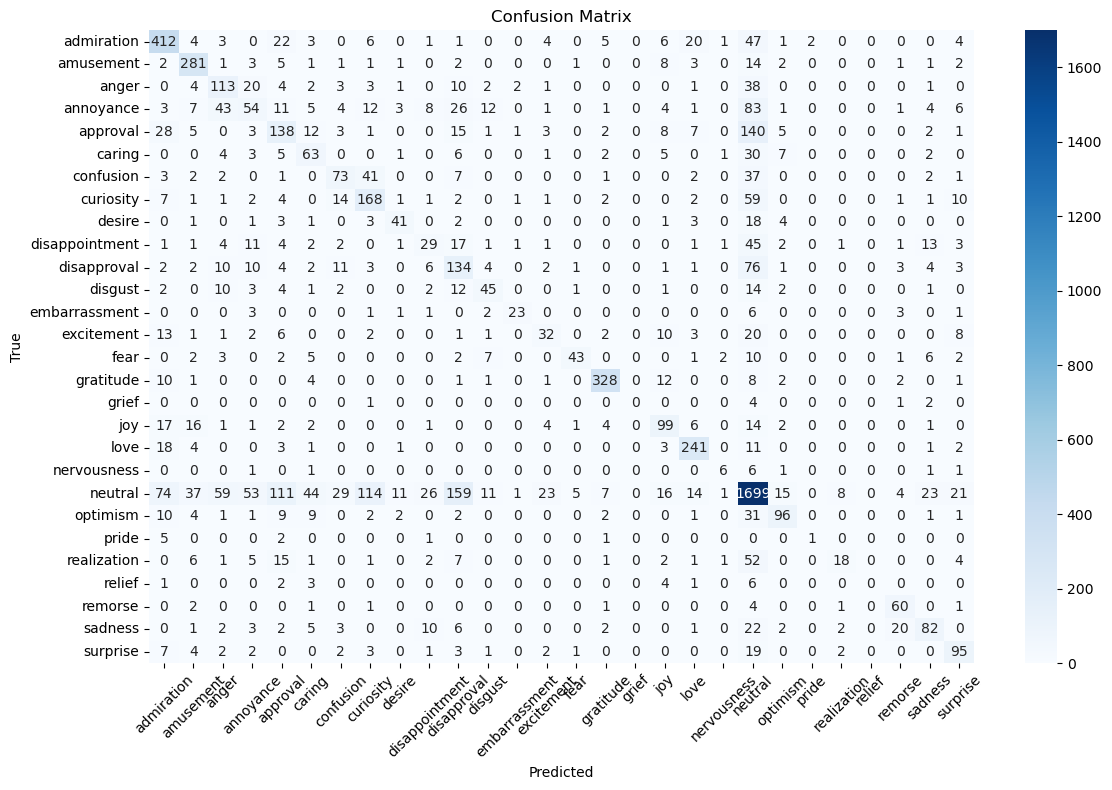

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot it
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(metrics_dir / "confusion_matrix.png")
plt.show()